# **Import Library**

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
print(tf.__version__)

2.18.0


# **Upload Data dari Kaggle**

In [5]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadzulzhafran","key":"5686cda5cf3ae2a4d173988f5d2bc804"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0


In [8]:
!unzip vegetable-image-dataset.zip -d vegetable-image-dataset

Streaming output truncated to the last 5000 lines.
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: 

In [9]:
dataset_path = 'vegetable-image-dataset'
for root, dirs, files in os.walk(dataset_path):
    print(f'📁 {root}')
    for file in files[:5]:  # Menampilkan 5 file pertama di setiap folder
        print(f'   📄 {file}')

📁 vegetable-image-dataset
📁 vegetable-image-dataset/Vegetable Images
📁 vegetable-image-dataset/Vegetable Images/train
📁 vegetable-image-dataset/Vegetable Images/train/Brinjal
   📄 0565.jpg
   📄 0859.jpg
   📄 0227.jpg
   📄 0971.jpg
   📄 0612.jpg
📁 vegetable-image-dataset/Vegetable Images/train/Pumpkin
   📄 0565.jpg
   📄 0859.jpg
   📄 0227.jpg
   📄 0971.jpg
   📄 0612.jpg
📁 vegetable-image-dataset/Vegetable Images/train/Carrot
   📄 0565.jpg
   📄 0859.jpg
   📄 0227.jpg
   📄 0971.jpg
   📄 0612.jpg
📁 vegetable-image-dataset/Vegetable Images/train/Potato
   📄 0565.jpg
   📄 0859.jpg
   📄 0227.jpg
   📄 0971.jpg
   📄 0612.jpg
📁 vegetable-image-dataset/Vegetable Images/train/Cauliflower
   📄 0565.jpg
   📄 1024.jpg
   📄 0859.jpg
   📄 0227.jpg
   📄 0971.jpg
📁 vegetable-image-dataset/Vegetable Images/train/Tomato
   📄 0565.jpg
   📄 0859.jpg
   📄 0227.jpg
   📄 0971.jpg
   📄 0612.jpg
📁 vegetable-image-dataset/Vegetable Images/train/Bean
   📄 0565.jpg
   📄 1024.jpg
   📄 0859.jpg
   📄 0227.jpg
   📄 0971

# **Data Pre-processing**

In [10]:
data_train = 'vegetable-image-dataset/Vegetable Images/train'
data_val = 'vegetable-image-dataset/Vegetable Images/validation'
data_test = 'vegetable-image-dataset/Vegetable Images/test'

## **Augmentasi & Generator**

In [12]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [13]:
train_generator = datagen.flow_from_directory(
    data_train,
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

Found 12000 images belonging to 15 classes.


In [14]:
val_generator = datagen.flow_from_directory(
    data_val,
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 600 images belonging to 15 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    data_test,
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 3000 images belonging to 15 classes.


# **Modelling**

## **Model Arsitektur CNN dan Compile Model**

In [16]:
tf.keras.backend.clear_session()
model = Sequential()

# 1st Convolutional layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers + Dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(15, activation='softmax'))

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00009),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,847,823 (18.49 MB)

 Trainable params: 4,847,375 (18.49 MB)

 Non-trainable params: 448 (1.75 KB)

## **Callbacks**

In [17]:
class StopAtAccuracy(Callback):
    def __init__(self, threshold=0.95):
        super(StopAtAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.threshold and val_acc >= self.threshold:
                print(f"\n Akurasi mencapai {self.threshold*100:.0f}% pada train & val. Menghentikan training.")
                self.model.stop_training = True

In [18]:
stop_acc_callback = StopAtAccuracy(threshold=0.95)

In [19]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    ),
    stop_acc_callback
]

## **Training Model**

In [20]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 280ms/step - accuracy: 0.2506 - loss: 2.6045 - val_accuracy: 0.0667 - val_loss: 6.1143 - learning_rate: 9.0000e-05
Epoch 2/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 270ms/step - accuracy: 0.5250 - loss: 1.5265 - val_accuracy: 0.2917 - val_loss: 2.7623 - learning_rate: 9.0000e-05
Epoch 3/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 231ms/step - accuracy: 0.6292 - loss: 1.1876 - val_accuracy: 0.6450 - val_loss: 1.2128 - learning_rate: 9.0000e-05
Epoch 4/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.7079 - loss: 0.9499 - val_accuracy: 0.8767 - val_loss: 0.4738 - learning_rate: 9.0000e-05
Epoch 5/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - accuracy: 0.7629 - loss: 0.7829 - val_accuracy: 0.8867 - val_loss: 0.4035 - learning_rate: 9.0000e-05
Epoch 6/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 258ms/step - accuracy: 0.8019 - loss: 0.6403 - val_accuracy: 0.9317 - val_loss: 0.2659 - learning_rate: 9.0000e-05
Epoch 7/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 23

# **Plot Akurasi dan Loss Model**

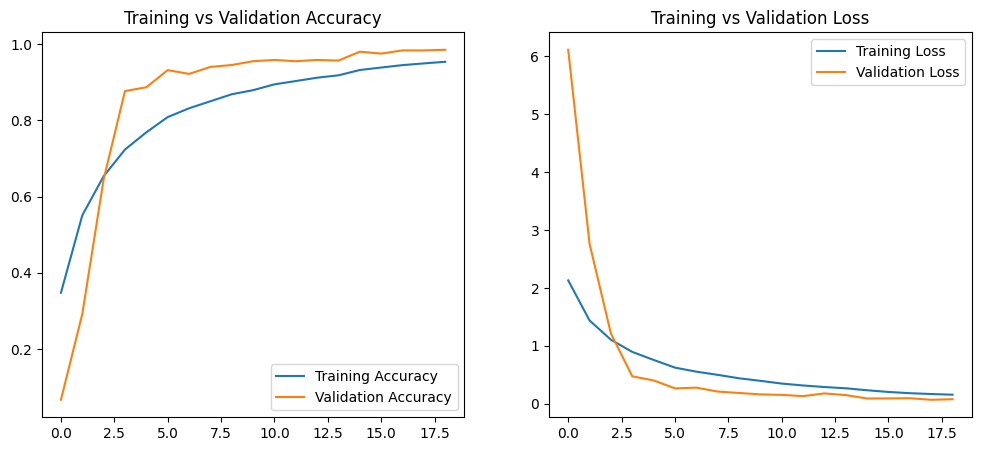

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


In [23]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi Training Terakhir: {final_train_acc:.2%}")
print(f"Akurasi Validation Terakhir: {final_val_acc:.2%}")

Akurasi Training Terakhir: 95.35%
Akurasi Validation Terakhir: 98.50%


# **Menyimpan Model ke Dalam Format SavedModel, TF-Lite dan TFJS**

## **SavedModel**

In [46]:
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  134142298553808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134144756900752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134142292380944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134142292382288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134142292380752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134142292381520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134142292383056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134142292383824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134142292384208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134142292385552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134142292383440: T

## **TF-Lite**

In [47]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Simpan ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [48]:
class_names = sorted(os.listdir(data_train))

with open("label.txt", "w") as f:
    for class_name in class_names:
        f.write(class_name + "\n")

print("label.txt dibuat")

label.txt dibuat


## **TFJS**

In [42]:
!pip install tensorflowjs

In [43]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/

2025-04-25 20:25:56.085120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745612756.122835   12014 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745612756.134334   12014 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-25 20:26:04.452706: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745612764.460864   12014 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## **Simpan ke GoogleDrive**

In [44]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

os.makedirs('temp_model_dir', exist_ok=True)

# Pindahkan semua file dan folder ke folder sementara
shutil.move('model.tflite', 'temp_model_dir/model.tflite')
shutil.move('tfjs_model', 'temp_model_dir/tfjs_model')
shutil.move('saved_model', 'temp_model_dir/saved_model')
shutil.move('label.txt', 'temp_model_dir/label.txt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'temp_model_dir/label.txt'

In [45]:
drive_target = '/content/drive/MyDrive/Submission_Klasifikasi_Gambar'

# Hapus folder tujuan di Drive jika sudah ada, lalu salin
if os.path.exists(drive_target):
    shutil.rmtree(drive_target)
shutil.copytree('temp_model_dir', drive_target)

'/content/drive/MyDrive/Submission_Klasifikasi_Gambar'

# **Inference**

In [49]:
import numpy as np

In [53]:
# Load model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load label
with open("label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

In [59]:
# Load
img = Image.open("testing_image.jpg")
img = img.resize((100, 100))
img = np.array(img, dtype=np.float32)
img = img / 255.0
img = np.expand_dims(img, axis=0)

interpreter.set_tensor(input_details[0]['index'], img)

# inferensi
interpreter.invoke()

# hasil
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

print(f"Predicted label: {labels[predicted_class]}")

Predicted label: Capsicum


In [60]:
# Load
img = Image.open("testing_image2.jpg")
img = img.resize((100, 100))
img = np.array(img, dtype=np.float32)
img = img / 255.0
img = np.expand_dims(img, axis=0)

interpreter.set_tensor(input_details[0]['index'], img)

# inferensi
interpreter.invoke()

# hasil
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

print(f"Predicted label: {labels[predicted_class]}")

Predicted label: Radish
